# Predicción de precios de automóviles

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

Primero se crearán las clases de regresión lineal. Para el inciso <b>a)</b> se usará mínimos cuadrados por descomposición QR.

In [2]:
## Super-clase de regresión lineal
class RegresionLineal:
    ## Entrenamiento
    def fit(self, X, y):
        self._estima_parametros(X, y)
    ## Predice los valores de los vectores dados.
    def predict(self, X):
        return X @ self.parameters

In [3]:
## Sub-clase de mínimos cuadrados QR
class MinimosCuadradosQR(RegresionLineal):
    def _estima_parametros(self, X, y):
        q, r = np.linalg.qr(X)
        print(r.shape)
        self.parameters = np.linalg.inv(r) @ q.T @ y

Se define la función de error cuadrático medio

In [4]:
ecm = lambda y, y_hat: ((y-y_hat)**2).sum()/y.shape[0]

Ahora se define la expansión polinomial de un conjunto de datos.

In [5]:
def expol(X, grado):
    phi_X = X
    for i in range(grado-1):
        powerX = np.power(X, i+2)
        phi_X = np.column_stack((phi_X, powerX))
    unos = np.ones(phi_X.shape[0])
    return np.column_stack((unos, phi_X))

## Validación cruzada

Se definirá una función que calcula el error cuadrático medio en validación cruzada con $k$ particiones y $r$ repeticiones. Recibe un modelo de regresión lineal. Recibe los valores de $x$ y $y$.

In [6]:
## Función que parte los datasets X y y, donde se tendrán k particiones de validación.
def parte(X, y, k, indice):
    tam_val = X.shape[0] // k # Tamaño de la partición
    X_ent = []
    X_val = []
    y_ent = []
    y_val = []
    for i in range(X.shape[0]):
        if tam_val*indice <= i and i < tam_val*(indice+1):
            X_val.append(X[i])
            y_val.append(y[i])
        else:
            X_ent.append(X[i])
            y_ent.append(y[i])
    return (np.array(X_ent), np.array(X_val), np.array(y_ent), np.array(y_val))

In [7]:
## Realiza validación cruzada con k particiones y r repeticiones.
# @param k particiones
# @param r repeticiones
# @param X matriz con valores de x
# @param y vector con valores de y
# @param rl modelo de regresión lineal
# @param grado de la expansión polinomial
# @return errores cuadráticos medios, para entrenamiento y validación
def validacion_cruzada_kr(k, r, X, y, rl, grado):
    suma_errores_ent = 0
    suma_errores_val = 0
    X_expand = expol(X, grado) #expansión sobre x
    for i in range(r):
        perms = np.random.permutation(X.shape[0]) # permutación aleatoria de índices
        Xperm = X_expand[perms]
        yperm = y[perms]
        for j in range(k):
            X_ent, X_val, y_ent, y_val = parte(Xperm, yperm, k, j)
            rl.fit(X_ent, y_ent)
            y_pred_ent = rl.predict(X_ent)
            y_pred_val = rl.predict(X_val)
            suma_errores_ent += ecm(y_ent, y_pred_ent)
            suma_errores_val += ecm(y_val, y_pred_val)
    # Al final se saca el promedio de cada uno
    pecm_ent = suma_errores_ent / (r*k)
    pecm_val = suma_errores_val / (r*k)
    return (pecm_ent, pecm_val)

A continuación se leen los datos.

In [8]:
datacsv = pd.read_csv('imports-85_v2.csv')
datanp = datacsv.to_numpy()
num_data = datanp.shape[0] # número total de datos (de filas)
num_vars = datanp.shape[1]-1 # número total de variables (columnas-1)
# Se realiza la separación de los datos entre X y y
X_input = datanp[:, :-1]
y_input = datanp[:, -1]
# Se tomarán un 10% de los datos para el conjunto de prueba.
X_pl = []
y_pl = []
X_lista = []
y_lista = []
for i in range(X_input.shape[0]):
    if i < (X_input.shape[0]*0.9):
        X_lista.append(X_input[i])
        y_lista.append(y_input[i])
    else:
        X_pl.append(X_input[i])
        y_pl.append(y_input[i])
X = np.array(X_lista)
y = np.array(y_lista)
X_prueba = np.array(X_pl)
y_prueba = np.array(y_pl)

## Regresión lineal sin penalización

Se probarán los grados de polinomios desde 1 hasta 10 y se graficarán los errores cuadráticos medios.

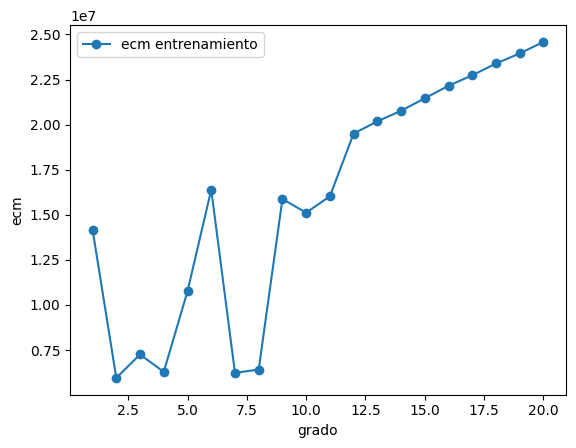

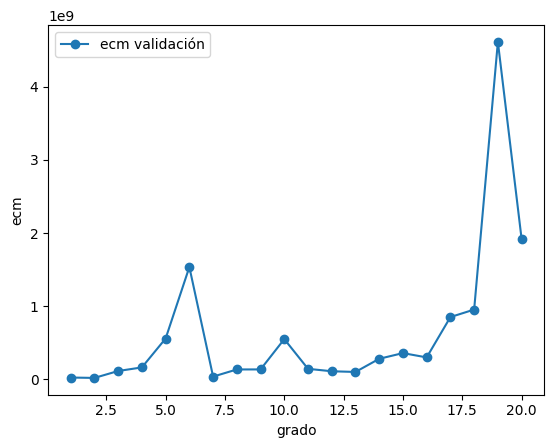

In [9]:
def grafica_inciso_a():
    ecm_ent = []
    ecm_val = []
    abscisas = []
    for i in range(1,21):
        rl = linear_model.LinearRegression()
        error_ent, error_val = validacion_cruzada_kr(5, 10, X, y, rl, i)
        ecm_ent.append(error_ent)
        ecm_val.append(error_val)
        abscisas.append(i)
    
    # Gráficas de líneas
    fig1, ax1 = plt.subplots()
    plt.xlabel('grado')
    plt.ylabel('ecm')
    ax1.plot(abscisas, ecm_ent, marker = "o", label = "ecm entrenamiento")
    ax1.legend()
    
    fig2, ax2 = plt.subplots()
    plt.xlabel('grado')
    plt.ylabel('ecm')
    ax2.plot(abscisas, ecm_val, marker = "o", label = "ecm validación")
    ax2.legend()

grafica_inciso_a()

## Regresión con penalización por norma $l_2$

Se usará regresión lineal con penalización por norma $l_2$. Se usarán diferentes valores de $\lambda$ (o $\alpha$ en sklearn), con un polinomio de grado 20 y se graficarán los errores. Se usa descomposición QR.

In [10]:
class MinimosCuadradosL2QR(RegresionLineal):
    def __init__(self, lc = 0.01):
        self._lc = lc
        
    def _estima_parametros(self, X, y):
        lcI = np.sqrt(self._lc*np.identity(X.shape[1]))
        X_tilde = np.concatenate((X, lcI))
        y_tilde = np.concatenate((y, np.zeros(X.shape[1])))
        q, r = np.linalg.qr(X_tilde)
        self.parameters = np.linalg.inv(r) @ q.T @ y_tilde

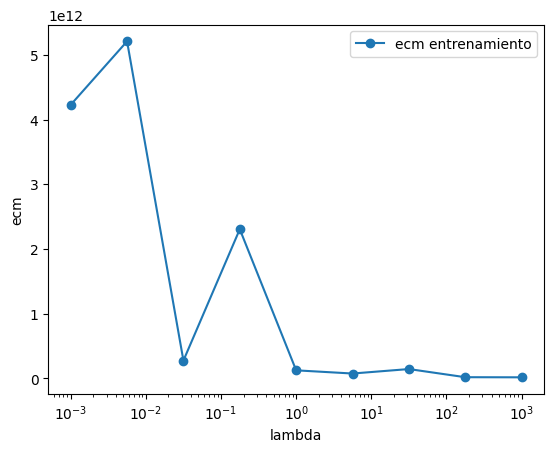

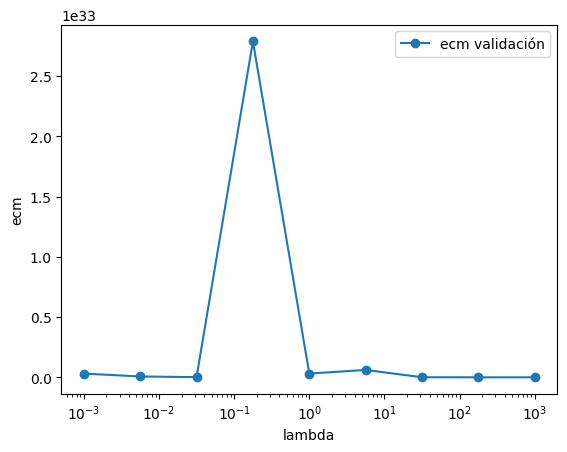

In [11]:
def grafica_inciso_bl2():
    ecm_ent = []
    ecm_val = []
    lambdas = np.geomspace(1e-3, 1e3, num=9)
    for lam in lambdas:
        rl = MinimosCuadradosL2QR(lam)
        error_ent, error_val = validacion_cruzada_kr(5, 10, X, y, rl, 20)
        ecm_ent.append(error_ent)
        ecm_val.append(error_val)
    
    # Gráficas de líneas
    fig1, ax1 = plt.subplots()
    plt.xscale('log')
    plt.xlabel('lambda')
    plt.ylabel('ecm')
    ax1.plot(lambdas, ecm_ent, marker = "o", label = "ecm entrenamiento")
    ax1.legend()
    
    fig2, ax2 = plt.subplots()
    plt.xscale('log')
    plt.xlabel('lambda')
    plt.ylabel('ecm')
    ax2.plot(lambdas, ecm_val, marker = "o", label = "ecm validación")
    ax2.legend()

grafica_inciso_bl2()

## Regresión con penalización por norma $l_1$.

Se usará el objeto Lasso de sklearn, el cual hace regresión con penalización por norma $l_1$.

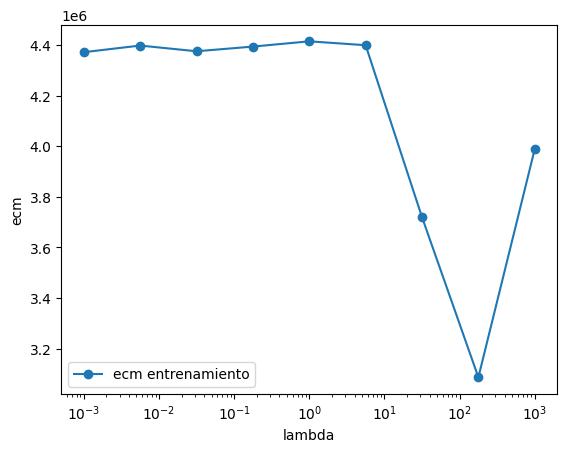

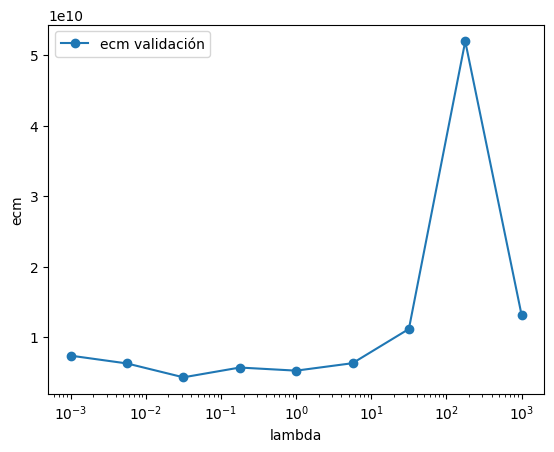

In [12]:
def grafica_inciso_bl1():
    ecm_ent = []
    ecm_val = []
    lambdas = np.geomspace(1e-3, 1e3, num=9)
    for lam in lambdas:
        rl = linear_model.Lasso(alpha = lam, max_iter = 5000, tol = 0.1)
        error_ent, error_val = validacion_cruzada_kr(5, 10, X, y, rl, 20)
        ecm_ent.append(error_ent)
        ecm_val.append(error_val)
    
    # Gráficas de líneas
    fig1, ax1 = plt.subplots()
    plt.xscale('log')
    plt.xlabel('lambda')
    plt.ylabel('ecm')
    ax1.plot(lambdas, ecm_ent, marker = "o", label = "ecm entrenamiento")
    ax1.legend()
    
    fig2, ax2 = plt.subplots()
    plt.xscale('log')
    plt.xlabel('lambda')
    plt.ylabel('ecm')
    ax2.plot(lambdas, ecm_val, marker = "o", label = "ecm validación")
    ax2.legend()

grafica_inciso_bl1()

## Selección de atributos

Ahora se usará el método de selección hacia adelante para seleccionar atributos. La estrategia que se usará será similar al ordenamiento por selección, excepto que en vez de seleccionar al elemento menor, se selecciona la columna tal que al agregarlo al conjunto ya existente, se obtenga el error cuadrático medio más pequeño.

In [13]:
## Se seleccionan las primeras columnas que disminuyan el error.
# @param num_cols el número de variables que se van a seleccionar. Debe ser mayor o igual 1.
# @return lista de columnas seleccionadas
def seleccion_adelante(num_cols, grado):
    seleccionadas = [] # lista de columnas seleccionadas
    # se elige la primera columna
    pc = X[:,0]
    pc2 = pc[:,np.newaxis]
    salida = pc2
    rl = linear_model.LinearRegression()
    error_ent, error_val = validacion_cruzada_kr(5, 10, salida, y, rl, grado)
    min_err_1c = error_val
    pcs = 0 # primera columna seleccionada
    for i in range(1, X.shape[1]):
        col = X[:,i]
        col2 = col[:,np.newaxis]
        salida = col2
        error_ent, error_val = validacion_cruzada_kr(5, 10, salida, y, rl, grado)
        if error_val < min_err_1c:
            min_err_1c = error_val
            pcs = i
    # se borra esa columna de la matriz
    seleccionadas.append(pcs)
    # Ahora se eligen el resto de las columnas
    for i in range(1, num_cols):
        min_err = float('inf')
        col_selec = -1
        for j in range(X.shape[1]):
            if not (j in seleccionadas):
                col = X[:,j] # selección de columna j
                col2 = col[:,np.newaxis] # transformación a vector columna
                salida = np.concatenate([salida, col2], axis=1) # se pega esa columna a la salida actual
                error_ent, error_val = validacion_cruzada_kr(5, 10, salida, y, rl, 2) # cálculo del error
                if error_val < min_err: # si disminuye el error, se selecciona esta nueva columna
                    min_err = error_val
                    col_selec = j
                salida = np.delete(salida, -1, axis = 1) # se borra la última columna de salida
        seleccionadas.append(col_selec)
        cs = X[:,col_selec]
        cs2 = cs[:,np.newaxis]
        salida = np.concatenate([salida, cs2], axis = 1) # se pega la columna seleccionada a la salida
    return seleccionadas

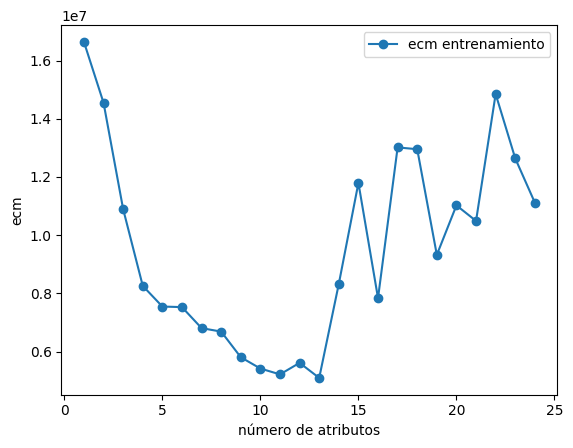

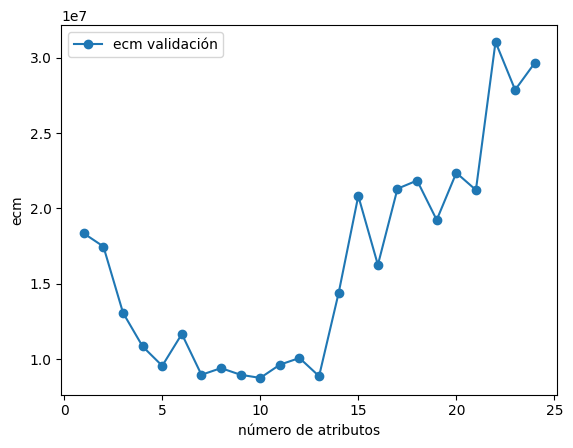

In [14]:
def grafica_inciso_c():
    ecm_ent = []
    ecm_val = []
    num_atr = []
    for i in range(1, num_vars):
        rl = linear_model.LinearRegression()
        subset = seleccion_adelante(i, 2)
        subset.sort()
        X2 = X[:,subset]
        error_ent, error_val = validacion_cruzada_kr(5, 10, X2, y, rl, 2)
        ecm_ent.append(error_ent)
        ecm_val.append(error_val)
        num_atr.append(i)
    
    fig1, ax1 = plt.subplots()
    plt.xlabel('número de atributos')
    plt.ylabel('ecm')
    ax1.plot(num_atr, ecm_ent, marker = "o", label = "ecm entrenamiento")
    ax1.legend()
    
    fig2, ax2 = plt.subplots()
    plt.xlabel('número de atributos')
    plt.ylabel('ecm')
    ax2.plot(num_atr, ecm_val, marker = "o", label = "ecm validación")
    ax2.legend()
    
grafica_inciso_c()

## Desempeño en conjunto de prueba

Decidí usar el modelo de expansión polinomial de grado 7, sin penalización, para el conjunto de prueba.

In [15]:
def reporte_prueba():
    rl = linear_model.LinearRegression()
    X_expand = expol(X, 6) # expansión sobre x
    rl.fit(X_expand, y) # entrenamiento
    X_exp_pru = expol(X_prueba, 6)
    y_pred_pru = rl.predict(X_exp_pru) # predicción
    ecm_pru = ecm(y_pred_pru, y_prueba)
    return ecm_pru

print("Error cuadrático medio en conjunto de prueba:", reporte_prueba())

Error cuadrático medio en conjunto de prueba: 57479175.259850524
